
## Face recognition using scikit-learn


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW:

http://vis-www.cs.umass.edu/lfw/

http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

code adapted from:
https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html


<img src="./faces.png">


### Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from time import time

%matplotlib inline


### Step 1) Get the data (I previously downloaded it and saved it)

In [14]:
saved_data = {}

saved_data = pickle.load(open('./data/faces/saved.pickle', 'rb'))
images = saved_data['images']
data = saved_data['data']
target = saved_data['target']
target_names = saved_data['target_names']

# Find how many images we have and image height and width (for plotting)
n_samples, h, w = images.shape
np.random.seed(42)

X = data

n_features = X.shape[1]

# the label to predict is the id of the person
y = target
target_names = target_names
n_classes = target_names.shape[0]

### Step 2) Split into training and test sets

In [15]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print('Training dataset size:')
print('n_samples: %d' % X_train.shape[0])

print('Test dataset size:')
print('n_samples: %d' % X_test.shape[0])

Training dataset size:
n_samples: 966
Test dataset size:
n_samples: 322


### Step 3) Pre-process the data

#### Compute a PCA (eigenfaces) on the face dataset

**This is a dimension reduction step**

In [16]:
n_components = 150

print('Extracting the top %d eigenfaces from %d faces'
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print('done in %0.3fs' % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print('done in %0.3fs' % (time() - t0))

print('Original dataset size:')
print('n_samples: %d' % X_train.shape[0])
print('n_features: %d' % X_train.shape[0])

print('Processed dataset size:')
print('n_samples: %d' % X_train_pca.shape[0])
print('n_features: %d' % X_train_pca.shape[1])

Extracting the top 150 eigenfaces from 966 faces
done in 1.256s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.093s
Original dataset size:
n_samples: 966
n_features: 966
Processed dataset size:
n_samples: 966
n_features: 150


### Step 4) Train the ML model - here the Scikit-Learn Support Vector Classifier 

**We train only on the 'train' dataset and hold back the test data to evaluate the model**

In [17]:
print('Fitting the classifier to the training set')
t0 = time()


clf = SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))

# 6.394s vs 0.292s

Fitting the classifier to the training set
done in 0.290s


### Step 5) Test the model

**Here we use the test dataset which the model did not 'see' during training**

In [18]:
print('Predicting names on the test set')
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting names on the test set
done in 0.070s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

         accuracy                           0.83       322
        macro avg       0.77      0.77      0.76       322
     weighted avg       0.84      0.83      0.83       322

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


### Evaluate by plotting some results

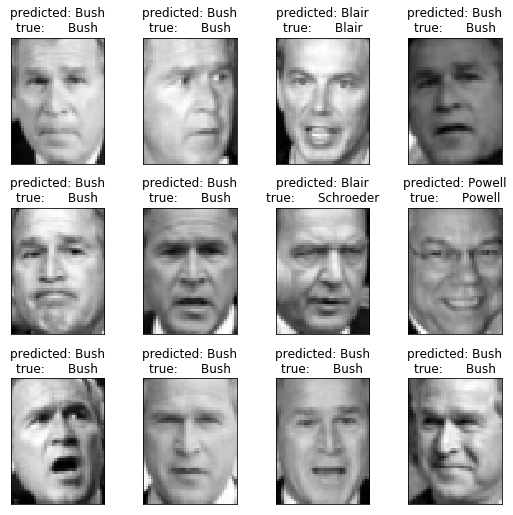

In [19]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


### What are the 'eigenfaces'

**They are composite components created during the PCA step that are most informative in distiguishing faces**

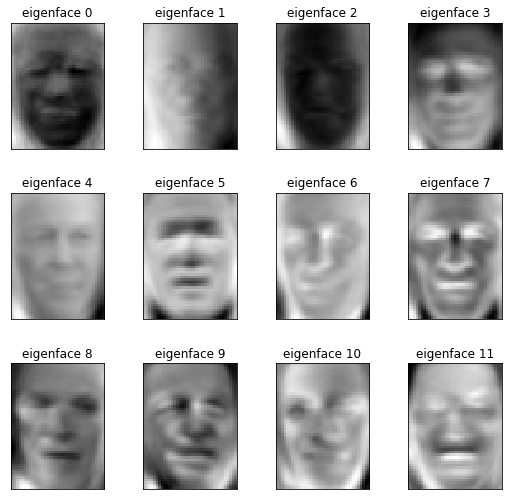

In [8]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)